This program deals with data for picosecond acoustics and time domain brillouin scattering experiments. From a time delay vs reflectivity data, this code will remove the smooth thermal background using a N polynomial fit. A sinusodial fit will be carried out on the resultant residual to detect any Bruillouin modes in the residual (acoustic) data. Detection of the primary sine wave is done automatically. The polynomial/sinusoidal fit should work independently of the averaging, so the code should work regardless of the type of signal averaging done, as long as the input data has atleast two columns in it, one of them labeled "time delay" and the other one labeled "V_in" (pretty standard for TDTR and picosecond acoustics). You can check the "averaged_test" file as an example of the general layout of input. I have made the main code body to be a function so it can be called in a loop (makes fitting multiple datasets easier). The folder should include an averaging code that is a bit specific to the LabView code that I programmed, so I doubt that code will carry over well, but this code is equipped to handle any time delay/ refletance data you throw at it.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import optimize


In [2]:
#importing data for testing.
inp_file = "averaged_test"

In [3]:
#define a sine function that will used in the fit later. A is the amplitude, f is the frequency and p is the phase shift. 
def s_fxn(x, A, f, p, c):
    return A * np.sin( 2 * np.pi * f * x + p) + c

The main fitting function. This function will first use a polynomial fit to remove the smoothly decaying background of the 
data followed by a sine fit to the residual. The form of the sine function is shown above. The ampltiude, phase, frequency and y intercet is returned. The error in the fit (average of root squared difference) is also output. For input, the system takes in the filename of the raw data and order of polynomial (default is 5; check figures to ensure the fit is good)

In [4]:
def fit_fxn(filename, poly_odr = 5):
    #import raw data as a pandas series:
    main_data = pd.read_csv(filename)
    
    #internal testing; comment out:
    #print(main_data.head())
    
    #perform a polynomial fit of specified order.
    #this will provide the coefficients to a poly_odr fit to the data.
    poly_coeff = np.polynomial.polynomial.polyfit(main_data['time delay'], main_data['V_in'], poly_odr)
    
    #we define a function that can take in a x value and calculated "y" for the poy function
    poly_fun = np.polynomial.Polynomial(poly_coeff)
    
    #now we calculate the background and add it to the dataframe:
    main_data.insert(len(main_data.columns), 'poly fit', poly_fun(main_data['time delay']))
    
    
    #calculation of residuals:
    main_data.insert(len(main_data.columns), 'poly res', main_data['V_in'] - main_data['poly fit'])
    
    #plotting out raw data and polyfit for inspection:
    
    fig_ax = main_data.plot.scatter(x = 'time delay', y = 'V_in', color = 'b', fontsize =12, title = filename )
    main_data.plot(x = 'time delay', y = 'poly fit', label = 'Background fit', linewidth = 2, color = 'g', ax = fig_ax)
    
    #additional formatting for graph:
    #fig_ax.set(xlabel = 'Time Delay / ps', ylabel = 'V_in / uV') 
    fig_ax.set_xlabel('Time Delay / ps', fontsize = 15 )
    fig_ax.set_ylabel('V_in / uV ', fontsize = 15 )
    
    #Now we move on to finding the primary mode of oscillation in the residual data.
    #All constants are unknown-- frequency, amplitude, phase, or the y intercept
    #We will try to fit them all using the optimize function in scipy which need a starting value
    #here we defined the initial guess:
    
    paraA = main_data['poly res'].max() 
    #straight forward; the amplitude paraA should be around the max deviation in the residual
    
    paraC = 0
    #since fitting residuals, the y intercept paraC should be centered around 0 or the initial fit was problematic
    
    paraP = main_data['time delay'].min()
    #the phase paraP will be within 2 pi of this point so a good guess all things considered
    
    
    #Intial guess for the frequency paraF requires some work:
    
    
    stepS = main_data['time delay'][2] - main_data['time delay'][1]
    #account for step size used to take data; units of time are ps; 
    #since fast fourier is done on a single column data, makes it necessary to pin down the step size in this manner
    
    fft_Arr = sp.fft(main_data['poly res'])
    fft_Pwr = np.abs(fft_Arr) ** 2
    #do fft of the series and calculate absolute values
    
    fft_FArr = np.fft.fftfreq(len(fft_Pwr), stepS / 1)
    #here we define the frequency rage by using step size previosualy defined
    #we then tie the amplitude array for FFT and the frequency together
    
    #I will now add everything to the main dataframe since why now:
    main_data.insert(len(main_data.columns), 'Residual FFT', fft_Pwr)
    main_data.insert(len(main_data.columns), 'Associated F', fft_FArr)
    #print(main_data.head())
    
    #''' 
    #Un/comment this portion to un/see FFt plots:
    
    fig_axfft = main_data.plot(x = 'Associated F', y = 'Residual FFT', logy = 1, ylim = [1e-1, 1e6], color = 'b', fontsize = 15, title = filename + ' residual FFT')
    fig_axfft.set(xlabel = 'Frequency / THz', ylabel = 'Amplitude')
    
    #'''
    
    #find the primary frequency associated with the largest amplitude, and this becomes our initial guess for frequency paraF:
    paraF = main_data['Associated F'][main_data['Residual FFT'].idxmax()]
    
    print('the Brillouin frequency is ' + f'{paraF * 1000 : 0.3}' + ' GHz')
    
    #Now we finally get to do the Sinosoidal fitting of the residual:
    sin_para, para = sp.optimize.curve_fit(s_fxn, main_data['time delay'], main_data['poly res'], p0 = [paraA, paraF, paraP, paraC])
    print('best ampltidude fit is '+ f'{sin_para[0] : 0.3}' + ' microVolts')
    
    
    #Might as well save the sine fit made so we can do things like estimate uncertainties and visualize data:
    main_data.insert(len(main_data.columns), 'Sine Res Fit', s_fxn(main_data['time delay'], sin_para[0], sin_para[1], sin_para[2], sin_para[3]))
    
    #Visualize this data:
    fig_ax2 = main_data.plot.scatter(x = 'time delay', y = 'poly res', color = 'b', label = 'Residual', fontsize = 15, title = filename + ' Sine fit to residual')    
    main_data.plot(x = 'time delay', y = 'Sine Res Fit', color = 'g', ax = fig_ax2, label = 'Sine fit')
    fig_ax2.set_xlabel('Time Delay / ps', fontsize = 15 )
    fig_ax2.set_ylabel('Residual V_in / uV', fontsize = 15 )
    
    #output file:
    main_data.to_csv('fitted_poly_odr_' + str(poly_odr) + ' ' + filename)
    
    #fit analysis:
    fit_res = main_data['Sine Res Fit']  - main_data['poly res']
    sq_fit  = fit_res ** 2
    err_fit = (sq_fit.sum()/len(sq_fit)) ** 0.5 
    
    print ('estimated uncertainty is ' + f'{err_fit:.3}' + ' microVolts')

the Brillouin frequency is  44.8 GHz
best ampltidude fit is  16.1 microVolts
estimated uncertainty is 2.47 microVolts


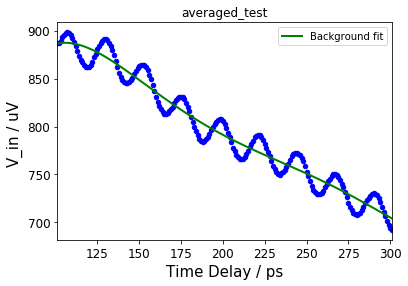

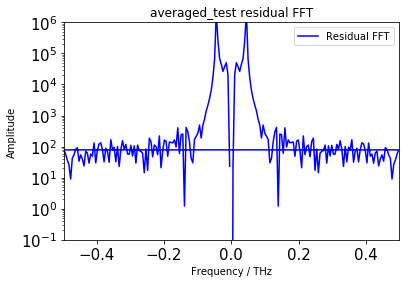

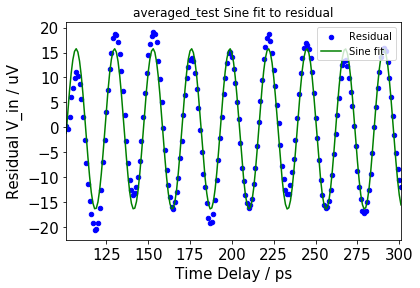

In [5]:
#test:
fit_fxn(inp_file)